In [29]:
from pathlib import Path
import os
workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL
Current working directory is now: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL


In [30]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, VectorDataset, stack_samples, unbind_samples
from torchgeo.samplers import RandomGeoSampler, GridGeoSampler

import geopandas as gpd


In [31]:
class DEMRast(RasterDataset):
    filename_glob = "*_huc_041402011002.tif"
    is_image = True
    separate_files = False
    
class NAIPRast(RasterDataset):
    filename_glob = "*_huc_041402011002*"
    is_image = True
    separate_files = False
    rgb_bands = ("r", "g", "b")


In [32]:
class LabelDataset(VectorDataset):
    filename_glob = "*041402011002*"
    class_map = {
        "EMW": 1,  # Emergent
        "FSW": 2,  # Forested
        "OWW": 3,  # Open Water
        "SSW": 4,  # Shrub
    }
    
    def __init__(self, paths, res=1, label_column="MOD_CLASS", **kwargs):
        self.label_column = label_column
        super().__init__(paths=paths, res=res, label_name=label_column, **kwargs)
    
    def get_label(self, feature):
        """Convert string labels to integers.
        
        Args:
            feature: A pandas Series (row from GeoDataFrame), not a GeoJSON dict.
        """
        label_str = feature[self.label_column]
        return self.class_map.get(label_str, 0)  # 0 for unknown/background

In [33]:
dem = DEMRast("Data/TerrainProcessed/HUC_DEMs/")
naip = NAIPRast("Data/NAIP/HUC_NAIP_Processed/")
labels = LabelDataset("Data/Training_Data/Wetland_Polygons_For_DL/")
ny_huc = gpd.read_file("Data/NY_HUCS/NY_Cluster_Zones_250_NAomit.gpkg")
huc = ny_huc[ny_huc['huc12'] == "041402011002"]
roi = huc.geometry.item()

In [34]:
print(labels)

LabelDataset Dataset
    type: GeoDataset
    bbox: (slice(np.float64(381947.96584875317), np.float64(398238.8788648841), 1), slice(np.float64(4706540.914523855), np.float64(4716426.481086308), 1), slice(Timestamp('1677-09-21 00:12:43.145224193'), Timestamp('2262-04-11 23:47:16.854775807'), 1))
    size: 1


In [35]:
cmb = dem & naip & labels

In [36]:
print(cmb)

IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: (slice(np.float64(381947.96584875317), np.float64(398238.8788648841), 1.0), slice(np.float64(4706540.914523855), np.float64(4716426.481086308), 1.0), slice(Timestamp('1677-09-21 00:12:43.145224193'), Timestamp('2262-04-11 23:47:16.854775807'), 1))
    size: 1


In [37]:
# Use RandomGeoSampler first to find valid data areas
# (GridGeoSampler starts at corner which may be nodata)
sampler = RandomGeoSampler(
    dataset=cmb, 
    size=128, 
    length=50,  # number of random samples to draw
    roi=roi
)

dataloader = DataLoader(
    cmb, 
    sampler=sampler, 
    batch_size=4,
    collate_fn=stack_samples
)

In [55]:
# Find a batch with valid data

def has_valid_data(batch, min_valid_ratio=0.7):
    """Check if batch has enough valid (non-nan) pixels."""
    image = batch['image']
    valid_ratio = (~torch.isnan(image)).float().mean().item()
    return valid_ratio > min_valid_ratio

valid_batch = None
for batch in dataloader:
    if has_valid_data(batch, min_valid_ratio=0.7):
        valid_batch = batch
        break

if valid_batch is not None:
    print("Found valid batch!")
    print(f"Image shape: {valid_batch['image'].shape}")
    print(f"Mask shape: {valid_batch['mask'].shape}")
    print(f"Valid pixel ratio: {(~torch.isnan(valid_batch['image'])).float().mean().item():.2%}")
    print(f"Unique mask values: {torch.unique(valid_batch['mask']).tolist()}")
else:
    print("No valid batches found - all samples hit nodata areas")

Found valid batch!
Image shape: torch.Size([4, 7, 128, 128])
Mask shape: torch.Size([4, 128, 128])
Valid pixel ratio: 75.00%
Unique mask values: [0]


In [74]:
len(dataloader)

13

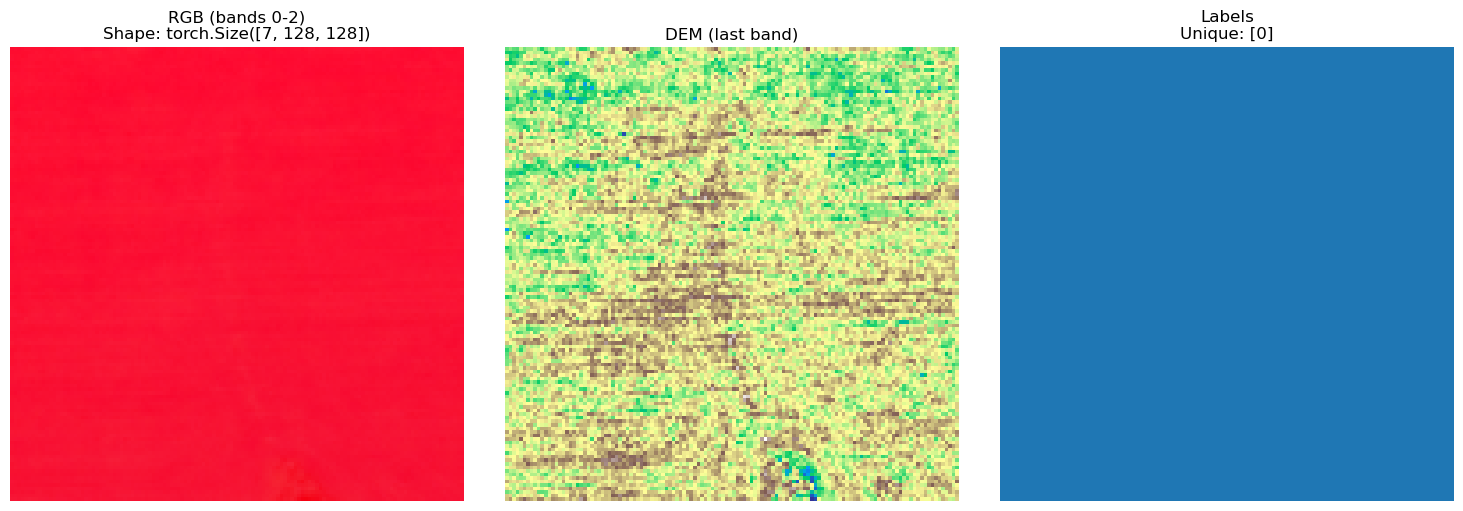

In [85]:
# Visualize the first sample from the valid batch
if valid_batch is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get first sample
    img = valid_batch['image'][0]  # Shape: (C, H, W)
    mask = valid_batch['mask'][0]  # Shape: (H, W)
    
    # Plot first 3 bands as RGB (assuming NAIP bands)
    rgb = img[:3].permute(1, 2, 0).numpy()  # (H, W, 3)
    # Replace nan with 0 for visualization
    rgb = np.nan_to_num(rgb, nan=0)
    # Normalize for display
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max > rgb_min:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    
    axes[0].imshow(rgb)
    axes[0].set_title(f'RGB (bands 0-2)\nShape: {img.shape}')
    axes[0].axis('off')
    
    # Plot DEM band (last band from DEM dataset)
    dem_band = img[-1].numpy()
    dem_band = np.nan_to_num(dem_band, nan=0)
    axes[1].imshow(dem_band, cmap='terrain')
    axes[1].set_title('DEM (last band)')
    axes[1].axis('off')
    
    # Plot mask
    axes[2].imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=4)
    axes[2].set_title(f'Labels\nUnique: {torch.unique(mask).tolist()}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid batch to visualize")

In [86]:
# Dataset diagnostics
print("=== Dataset Information ===")
print(f"\nDEM dataset:")
print(f"  Files: {dem.files}")
print(f"  CRS: {dem.crs}")
print(f"  Resolution: {dem.res}")

print(f"\nNAIP dataset:")
print(f"  Files: {naip.files}")
print(f"  CRS: {naip.crs}")
print(f"  Resolution: {naip.res}")

print(f"\nLabels dataset:")
print(f"  Files: {labels.files}")
print(f"  CRS: {labels.crs}")
print(f"  Resolution: {labels.res}")

print(f"\nCombined dataset bbox:")
print(f"  {cmb.bounds}")

=== Dataset Information ===

DEM dataset:
  Files: ['Data/TerrainProcessed/HUC_DEMs/cluster_208_huc_041402011002.tif']
  CRS: PROJCS["NAD83(2011) / UTM zone 18N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6347"]]
  Resolution: (1.0, 1.0)

NAIP dataset:
  Files: ['Data/NAIP/HUC_NAIP_Processed/cluster_208_huc_041402011002_NAIP_metrics.tif']
  CRS: PROJCS["NAD83(2011) / UTM zone 18N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Refere